In [140]:
import pandas as pd
import numpy as np
import seaborn as sb
from matplotlib import rc
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import time

from sklearn import model_selection
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, MultiTaskLasso, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score

In [2]:
%matplotlib inline
pd.set_option('max_columns',500)
font = {'size': 20}
rc('font', **font)
plt.style.use('seaborn-bright')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Data Cleaning

In [3]:
def date_to_int(row, col, df):
    index = df.columns.get_loc(col)
    date = row[index]
    return time.mktime(time.strptime(str(date), '%Y-%m-%d %H:%M:%S'))

In [4]:
def data_type(df):
    # datetime and date to int
    date_cols = ['visit_date', 'prev_visit_date', 'prev_item_move_date', 
                 'last_edit_date', 'creation_date']
    for col in date_cols:
        # convert multiple time formats into single string format
        df[col] = pd.to_datetime(df[col]).dt.strftime('%Y-%m-%d %H:%M:%S')
        # make time features specific data type in order to distinguish from other numberic values
        df['{}_int'.format(col)] = df.apply(date_to_int, col=col, df=df, axis=1).astype(np.float32)
        # convert string format back into datetime
        df[col] = pd.to_datetime(df[col])
    
    # objects
    obj_cols = ['ship_id', 'address1', 'customer_id', 'sales_rep_id', 'item_id', 'old_item_id', 
                'item_UPC', 'old_item_UPC', 'ship_list_pk', 'sales_rep_id_2', 'list_header_id']
    for col in obj_cols:
        df[col] = df[col].astype(object)

In [5]:
def nans(df):
    df.dropna(axis=0, inplace=True)
    # caution: crime data cuts total data in ~1/3

In [6]:
def zip_code_inc(row, df):
    index = df.columns.get_loc('postal_code')
    code = row[index]
    return int(code[:5])

In [7]:
def days_between_visits(df):
    out_arr = []
    i = 0
    for index, row in df.iterrows():
        diff = row['visit_date'] - row['prev_visit_date']
        out_arr.append(pd.Timedelta(diff).days)
    return out_arr

In [ ]:
# not working
def get_masked_df(df, level_list):
    for ff_val in df[first_filter].unique():
        ff_mask = df[first_filter] == ff_val
        for sf_val in df[ff_mask][second_filter].unique():
            sf_mask = df[second_filter] == sf_val
            for tf_val in df[ ff_mask & sf_mask][third_filter].unique():
                tf_mask = df[third_filter] == tf_val
                foo = df[ ff_mask & sf_mask & tf_mask ].sort_values('visit_date', ascending=False)
    return df[ mask ].sort_values('visit_date', ascending=False)

In [ ]:
# not working
def lag3(df, num_periods=1, first_filter='address1', second_filter='item_category', third_filter='item_upc'):
    # initialize column(s) of nans
    for period in range(1, num_periods + 1):
        if period == 1:
            continue
        df['qty_shrink_per_day_lag{}'.format(period)] = np.nan
        df['shrink_value_per_day_lag{}'.format(period)] = np.nan
        
    j = 0
    for ff_val in df[first_filter].unique():
        j += 1
        if j % 1000 == 0:
            print('another 10%...')
        ff_mask = df[first_filter] == ff_val
        for sf_val in df[ff_mask][second_filter].unique():
            sf_mask = df[second_filter] == sf_val
            for tf_val in df[ ff_mask & sf_mask][third_filter].unique():
                tf_mask = df[third_filter] == tf_val
                foo = df[ ff_mask & sf_mask & tf_mask ].sort_values('visit_date', ascending=False)
                #print('foo: ',foo[['visit_date']])
                length = len(foo.visit_date.unique()) # determine number of visits (because multiple item categories can be updated in a single visit)
                for period in range(1, num_periods + 1):
                    if period == 1:
                        continue
                    # skip if there's not enough data to create lag variables
                    filt_list = [first_filter, second_filter, third_filter]
                    end_of_filters = 0
                    while (length < period + 1) | end_of_filters:
                        foo = get_masked_df(df, filt_list)
                        # length = len(foo.visit_date.unique())
                        filt_list.pop()
                        continue
                    #print('length: ',length)
                    i = 0
                    foo_shifted = foo.shift(-period)
                    #print('fs: ', foo_shifted[['visit_date']])
                    foo_grouped = foo.groupby('visit_date').mean()
                    #print('fg: ', foo_shifted[['visit_date']])
                    for index, row in foo.iterrows():
                        #print(index)
                        date = foo_shifted[ foo_shifted.index == index].visit_date.values[0]
                        qty = foo_grouped[ foo_grouped.index == date].qty_shrink_per_day.values[0]
                        value = foo_grouped[ foo_grouped.index == date].shrink_value_per_day.values[0]
                        df.set_value(index, 'qty_shrink_per_day_lag{}'.format(period), qty)
                        df.set_value(index, 'shrink_value_per_day_lag{}'.format(period), value)
                        i += 1
                        #print(i)
                        if i + period == length:
                            break # back to cat loop

In [8]:
def lag(df, num_periods=1, first_filter='address1', second_filter='item_category', date_filter='visit_date',
        lag_var1='qty_shrink_per_day', lag_var2='shrink_value_per_day', col_name_suf=''):
    
    # initialize column(s) of nans
    for period in range(1, num_periods + 1):
#         if period == 1:
#             continue
        df['{}_lag{}{}'.format(lag_var1, period, col_name_suf)] = np.nan
        df['{}_lag{}{}'.format(lag_var2, period, col_name_suf)] = np.nan
        
    j = 0
    for ff_val in df[first_filter].unique():
        j += 1
        if j % 1000 == 0:
            print('another 9%...')
        ff_mask = df[first_filter] == ff_val
        for sf_val in df[ff_mask][second_filter].unique():
            sf_mask = df[second_filter] == sf_val
            foo = df[ ff_mask & sf_mask ].sort_values(date_filter, ascending=False)
            #print('foo: ',foo[['visit_date']])
            length = len(foo[date_filter].unique()) # determine number of visits (because multiple item categories can be updated in a single visit)
            for period in range(1, num_periods + 1):
#                 if period == 1:
#                     continue
                    
                # skip if there's not enough data to create lag variables
                if length < period + 1:
                    continue
                #print('length: ',length)
                i = 0
                foo_shifted = foo.shift(-period)
                #print('fs: ', foo_shifted[['visit_date']])
                foo_grouped = foo.groupby(date_filter).mean()
                #print('fg: ', foo_shifted[['visit_date']])
                for index, row in foo.iterrows():
                    #print(index)
                    date = foo_shifted[ foo_shifted.index == index][date_filter].values[0]
                    lag1_val = foo_grouped[ foo_grouped.index == date][lag_var1].values[0]
                    lag2_val = foo_grouped[ foo_grouped.index == date][lag_var2].values[0]
                    
                    # set values
                    df.set_value(index, '{}_lag{}{}'.format(lag_var1, period, col_name_suf), lag1_val)
                    df.set_value(index, '{}_lag{}{}'.format(lag_var2, period, col_name_suf), lag2_val)
                    i += 1
                    #print(i)
                    if i + period == length:
                        break # back to cat loop

In [ ]:
def lag_old(df, num_periods=1):
    df['qty_shrink_per_day_lag1'] = np.nan
    df['shrink_value_per_day_lag1'] = np.nan
    j = 0
    for add in df.address1.unique():
        j += 1
        if j % 1000 == 0:
            print('another 10%...')
        add_mask = df.address1 == add
        for cat in df[add_mask].item_category.unique():
            cat_mask = df.item_category == cat
            foo = df[ add_mask & cat_mask].sort_values('visit_date', ascending=False)
            #print('foo: ',foo[['visit_date']])
            length = len(foo.visit_date.unique()) # determine number of visits (because multiple item categories can be updated in a single visit)
            # skip if there's not enough data to create lag variables
            if length < num_periods + 1:
                continue
            #print(length)
            i = 1
            foo_shifted = foo.shift(-num_periods)
            #print('fs: ', foo_shifted[['visit_date']])
            foo_grouped = foo.groupby('visit_date').mean()
            for index, row in foo.iterrows():
                #print(index)
                date = foo_shifted[ foo_shifted.index == index].visit_date.values[0]
                qty = foo_grouped[ foo_grouped.index == date].qty_shrink_per_day.values[0]
                value = foo_grouped[ foo_grouped.index == date].shrink_value_per_day.values[0]
                df.set_value(index, 'qty_shrink_per_day_lag1', qty)
                df.set_value(index, 'shrink_value_per_day_lag1', value)
                i += 1
                #print(i)
                if i == length:
                    break # back to cat loop

In [14]:
def create(df, lag_periods):
    df['zip_code'] = df.apply(zip_code_inc, df=df, axis=1)
    
    # normalize target variables
    days_list = days_between_visits(df)
    df['qty_shrink_per_day'] = df.qty_shrink / days_list
    df['shrink_value_per_day'] = df.shrink_value / days_list
    
    # add lag variables
    lag(df, num_periods=lag_periods) # caution: takes a long time
    return df

In [15]:
def drop(df):
    del df['address3'] # redundant info (same as address 2)
    del df['postal_code'] # create zip code
    del df['duration'] # all zero values
    del df['dist_customer_id'] # all -1 values
    del df['POG_version_timestamp'] # dup of visit_date

In [16]:
def dummy(df):
    dummy_cols = ['item_category', 'customer_id']
    foo = pd.DataFrame()
    foo[dummy_cols] = df[dummy_cols].astype(str)
    df = pd.get_dummies(df, columns=dummy_cols)
    df[dummy_cols] = foo[dummy_cols]
    del foo
    return df

In [18]:
def clean(file, lag_periods, remove_nan_rows=True):
    df = pd.read_pickle(file)
    data_type(df)
    df = create(df, lag_periods)
    drop(df)
    df = dummy(df)
    if remove_nan_rows:
        nans(df)
    return df

In [19]:
# get SRP data and clean
df = clean(file='data/SRP/raw_subset.pkl', lag_periods=2, remove_nan_rows=False)
# lag of 2 seems to be best bet

/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


another 9%...
another 9%...
another 9%...
another 9%...
another 9%...
another 9%...
another 9%...
another 9%...
another 9%...
another 9%...
another 9%...


# Add public data

In [81]:
def add_data(df, include_crime=True, remove_nan_rows=True):
    # load data
    fd = pd.read_pickle('data/Food_Deserts/FD_clean.pkl').set_index('Zip Code')
    unemp = pd.read_pickle('data/Unemployment/unemp_clean.pkl').set_index('Zip')
    #inc = pd.read_pickle('data/Income/income_clean.pkl').set_index('ZIPCODE')
    dens = pd.read_pickle('data/Pop_Density/density_clean.pkl').set_index('Zip/ZCTA')
    crime = pd.read_pickle('data/Crime/grouped_clean.pkl').set_index(['state', 'city'])

    # join via zip code
    df = df.join(fd, on=['zip_code'], how='left')
    df = df.join(unemp, on=['zip_code'], how='left')
    # df = df.join(inc, on=['zip_code'], how='left')
    df = df.join(dens, on=['zip_code'], how='left')
    df['dens_sq_mile'] = df['dens/sq_mile'].replace(0, np.nan)
    del df['dens/sq_mile']
    
    # join via city/state
    if include_crime:
        df = df.join(crime, on=['state', 'city'], how='left')
        
    # drop all rows that contain nan
    if remove_nan_rows:
        nans(df)
        
    return df

In [82]:
def zip_code_str(row, df):
    index = df.columns.get_loc('zip_code')
    code = row[index]
    return str(code).zfill(5)

In [83]:
df = add_data(df, include_crime=False, remove_nan_rows=True)
df['zip_code'] = df.apply(zip_code_str, df=df, axis=1)

# still need to impute nans and 0's

# Split into features vs targets

In [84]:
def X_target(df, target_cols):
    target_data = df[target_cols]
    features = list(set(df) - set(target_cols))
    features.sort()
    X = df[features]
    return X, target_data

In [87]:
# split into features and targets
target_cols = ['shrink_value', 'shrink_to_sales_value_pct', 'shrink_value_out', 'shrink_to_sales_value_pct_out',
               'shrink_value_ex_del', 'shrink_to_sales_value_pct_ex_del', 'qty_inv_out', 'qty_shrink',
               'qty_shrink_ex_del', 'qty_shrink_out', 'qty_end_inventory', 'qty_f', 'qty_out', 'qty_ex_del',
               'qty_n', 'qty_delivery', 'qty_o', 'qty_d', 'qty_shrink_per_day', 'shrink_value_per_day']
X, target_data = X_target(df, target_cols)

In [88]:
# train test split
#y = target_data.shrink_value_per_day
y = target_data.qty_shrink_per_day

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standardize and Scale

In [91]:
def std_f(X_std):
    std_mask = (X_std.dtypes == int) | (X_std.dtypes == np.float64) # only standardize numbers that are not associated with time features
    std_cols = X_std.columns[std_mask]
    ss = StandardScaler()
    X_std[std_cols] = ss.fit_transform(X_std[std_cols])
    return X_std

In [92]:
def scale_f(X_sc):
    sc_mask = (X_sc.dtypes == np.float32) # only scale time features
    sc_cols = X_sc.columns[sc_mask]
    min_time = X_sc[sc_cols].min().values.min()
    max_time = X_sc[sc_cols].max().values.max()
    for col in sc_cols:
        # scale all time features using the same two values, so equivalent values reference the same date across columns
        X_sc[col] = (X_sc[col] - min_time) / (max_time - min_time)
    return X_sc

In [93]:
def ss(X_ss, std=True, scale=True):
    if not std and not scale:
        return
    X_new = X_ss.copy()
    if std:
        X_new = std_f(X_new)
    if scale:
        X_new = scale_f(X_new)
    return X_new

In [94]:
# standardize and scale data
X_train = ss(X_train, std=True, scale=True)
X_test = ss(X_test, std=True, scale=True)

In [96]:
X_train.head()

,FD_ratio,LAPOP1_10,POP2010,address1,address2,city,creation_date,creation_date_int,customer_id,customer_id_1635139,customer_id_1903139,customer_id_2139,customer_id_2331150,customer_id_2741156,customer_id_2773156,customer_id_2782156,customer_id_2956160,customer_id_2977160,customer_id_3083182,customer_id_3088198,customer_id_3088201,customer_id_3089336,customer_id_3093327,customer_id_3093329,dens_sq_mile,item_UPC,item_category,item_category_10,item_category_16,item_category_19,item_category_31,item_category_38,item_category_41,item_category_43,item_category_44,item_category_46,item_category_58,item_category_62,item_category_77,item_category_79,item_category_8,item_category_90,item_description,item_id,last_edit_date,last_edit_date_int,list_header_id,old_item_UPC,old_item_id,prev_item_move_date,prev_item_move_date_int,prev_visit_date,prev_visit_date_int,qty_POG_limit,qty_prev_end_inventory,qty_sales,qty_shrink_per_day_lag1,qty_shrink_per_day_lag2,qty_start_inventory,sales_rep_id,sales_rep_id_2,sales_value,ship_id,ship_list_pk,shrink_value_per_day_lag1,shrink_value_per_day_lag2,state,unemp_rate,unit_price,visit_date,visit_date_int,zip_code
4421580,-0.731229,1.487024,1.139525,7 ELEVEN SBT PROGRAM #26056,3302 E LAKE SAMMAMISH,SAMMAMISH,2016-08-23 07:37:37,0.0,2773156,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.054577,60870716238,16,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,VL MICRO CABLE 3' NYLON FLAT,2457135,2017-08-23 17:57:06,0.725458,4513311,60870716238,2457135,2017-10-30,0.858968,2017-10-30,0.858968,0.237500,0.269255,-0.113601,-0.235530,-0.352472,0.606949,100305135,100305135,-0.229763,160280,148395,-0.245486,-0.449763,WA,-1.382501,-0.933012,2017-11-28,0.916621,98075
4056840,-0.928514,-0.920729,-0.519392,SPEEDWAY #5237,1000 W MAIN ST,TIPP CITY,2016-08-23 07:37:37,0.0,2331150,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.525624,71941004001,44,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,5 HR PROTEIN-PEACH MANGO,2676135,2017-01-05 10:00:36,0.268283,3386280,71941004001,2676135,2017-08-16,0.710077,2017-08-30,0.737870,-0.400325,-0.540428,-0.431587,-1.076500,-0.234881,-0.231616,100287114,100287114,-0.557656,119472,138166,-0.729365,-0.333863,OH,-0.169679,-0.848909,2017-09-12,0.763677,45371
3279291,-0.454092,-0.932036,-0.549862,SPEEDWAY #5031,126 SW FIFTH ST,RICHMOND,2016-08-23 07:37:37,0.0,2331150,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.516807,60870716187,16,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,ELEC-APPLE 4' 30-PIN CHARGE/SYNC CABLE,2100130,2017-10-16 17:30:14,0.832622,3386280,60870716187,2100130,2017-11-20,0.900739,2017-12-04,0.928532,-0.559782,-0.540428,-0.431587,-0.172891,-0.117291,-0.536549,100063114,100063114,-0.557656,119215,137914,0.079584,0.118316,IN,1.043142,0.714412,2017-12-18,0.956325,47374
3185719,2.111192,-0.031795,-0.363308,SPEEDWAY #6629,1708 E 116TH ST,CARMEL,2016-08-23 07:37:37,0.0,2331150,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.121002,60870716188,16,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,ELEC-4' MICRO CHARGE/SYNC CABLE,2100131,2016-08-23 07:37:38,0.000000,3386280,60870716188,2100131,2017-11-28,0.916621,2017-11-28,0.916621,-0.347173,-0.324513,-0.431587,-0.293993,-0.156488,-0.231616,100063114,100063114,-0.557656,118233,139143,-0.375860,-0.266284,IN,-1.079295,0.125693,2017-12-12,0.944414,46032
1806867,1.427185,0.102254,-0.278435,SPEEDWAY #1251,260 S LOCUST ST,OXFORD,2016-08-23 07:37:37,0.0,2331150,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.530726,60870716191,16,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,ELEC-9' MICRO CHARGE/SYNC CABLE,2100134,2016-08-23 07:37:38,0.000000,3386280,60870716191,2100134,2017-09-07,0.753751,2017-09-11,0.761692,-0.506630,-0.486449,-0.272594,-0.051789,-0.078094,-0.536549,100100113,100100113,0.091572,119432,138499,0.244408,-0.061702,OH,0.133526,0.714412,2017-09-25,0.789485,45056


In [95]:
# create mask of all numberical columns to be used in clustering/modeling

# including time features
numb_mask = (X_train.dtypes == int) | (X_train.dtypes == np.float64) | (X_train.dtypes == np.float32) | (X_train.dtypes == np.uint8)
numb_cols = X_train.columns[numb_mask]

# not including time features
numb_no_time_mask = (X_train.dtypes == int) | (X_train.dtypes == np.float64) | (X_train.dtypes == np.uint8)
numb_no_time_cols = X_train.columns[numb_no_time_mask]

# mask to be used in calculations
model_mask_cols = numb_no_time_cols

In [ ]:
model_mask_cols

# Feature Importance
    - PCA
    - SVD
    - Random forest

## PCA

In [97]:
def plot_var(pca):
    '''
    Input: fitted PCA
    '''
    var_arr = np.insert(pca.explained_variance_ratio_, [0], 0)
    cum_arr = np.cumsum(var_arr)
    feat_arr = np.arange(0, len(var_arr), 1)
    
    plt.figure(figsize=(12,8))
    plt.plot(feat_arr, var_arr, label='Variance at each point', c='r')
    plt.plot(feat_arr, cum_arr, label='Cumulative variance')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.ylabel('Fraction of total variance explained')
    plt.xlabel('Principal Component')
    plt.xticks(feat_arr);

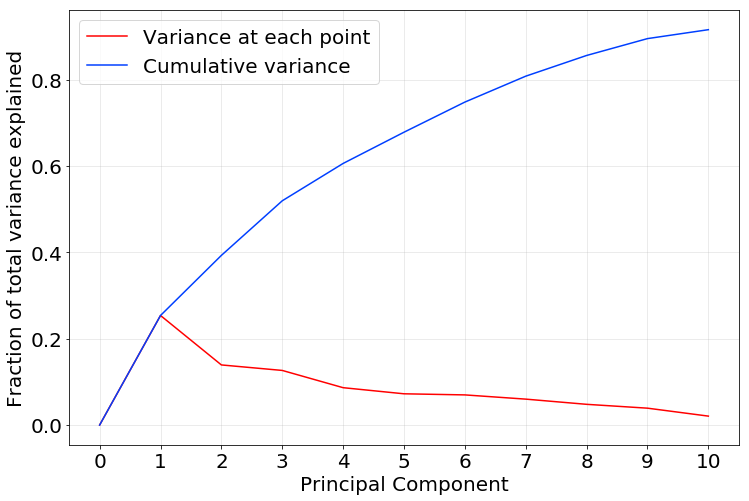

In [98]:
pca = PCA(10)
pca.fit(X_train[model_mask_cols])
plot_var(pca)

In [99]:
pca.components_

array([[ 3.16608784e-02, -4.10051108e-02, -5.26375216e-02,
        -4.08576287e-05, -2.76553505e-02, -6.05908941e-03,
         7.04802839e-02, -6.87656704e-05, -3.11880017e-02,
        -3.08882613e-04,  8.37554272e-24, -1.79902140e-03,
        -3.54955501e-04, -2.91142330e-03, -1.03421531e-24,
        -8.18208245e-05, -1.20166172e-26, -1.21153422e-05,
        -4.53222650e-02, -4.80607442e-02, -7.81539039e-02,
         0.00000000e+00,  0.00000000e+00,  9.02115692e-05,
         0.00000000e+00, -8.77693011e-05,  1.34735625e-01,
         0.00000000e+00, -2.19045958e-03, -3.97239852e-04,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -5.93571951e-03,  4.70233281e-01,  4.73106145e-01,
         3.94340195e-01,  9.37803853e-02,  4.68520013e-02,
         4.19849030e-01,  3.11194846e-01,  5.55235144e-03,
        -1.75660474e-02,  3.32442339e-02, -2.70412860e-01],
       [-1.53146460e-01,  4.20466040e-01,  4.73544492e-01,
        -2.08364189e-05, -4.70732267e-02, -4.47260719e-

## SVD

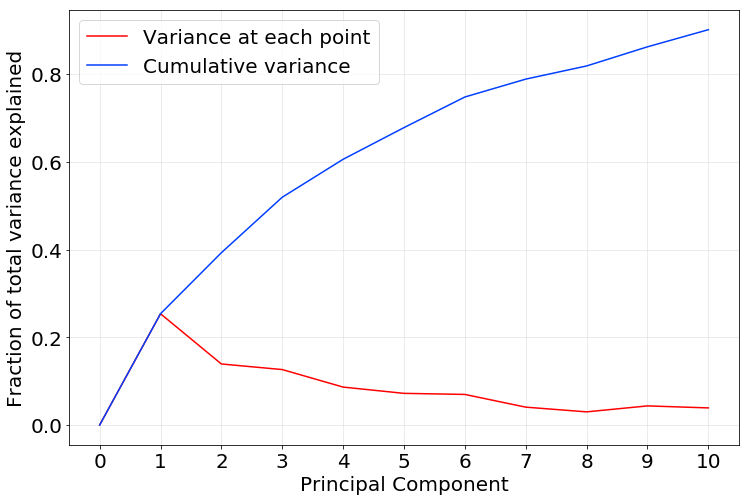

In [100]:
svd = TruncatedSVD(n_components=10)
svd.fit(X_train[model_mask_cols])
plot_var(svd)

# Clustering Models
Clustering models to try:
    - k-means
    - Heirarchal clustering
        - Look into the neat visualizations in R!
Link [here](http://www.sthda.com/english/wiki/beautiful-dendrogram-visualizations-in-r-5-must-known-methods-unsupervised-machine-learning)
    - Neural net
Perform for both subjective (features only) and objective (including targets/possibly even only targets)

## K-means

In [101]:
def kmeans(X_km, clusters):
    SSE_arr = []
    ss_arr = []
    for i in clusters:
        kmeans = KMeans(n_clusters=i, algorithm='auto', n_jobs=-1)
        clust_dist = kmeans.fit_transform(X_km)
        clust_num = kmeans.predict(X_km)

        SSE = 0
        for a, b in zip(clust_dist, clust_num):
            SSE += a[b] ** 2
        SSE_arr.append(SSE)
        
        if i > 1:
            ss_arr.append(silhouette_score(X_km, clust_num, sample_size=100))
    return SSE_arr, ss_arr

In [102]:
clusters = np.arange(1, 20)
SSE_arr, ss_arr = kmeans(X_train[model_mask_cols], clusters)

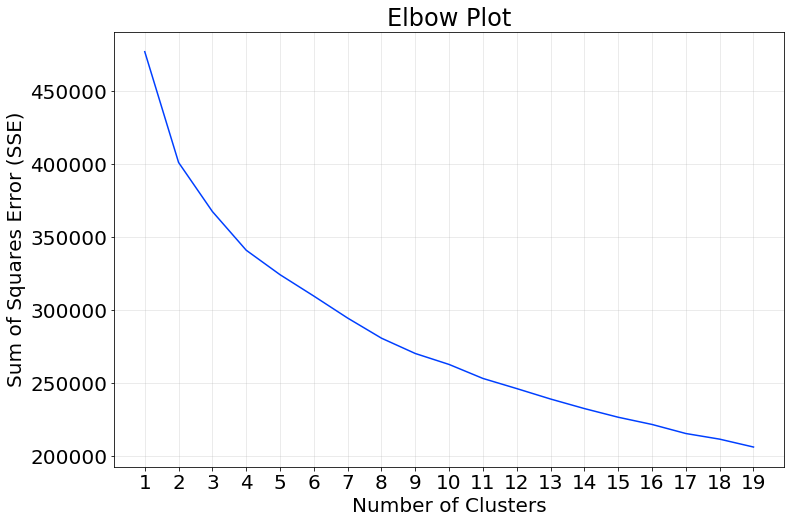

In [103]:
clusters_el = np.arange(1, 20)

plt.figure(figsize=(12,8))
plt.title('Elbow Plot')
plt.plot(clusters_el, SSE_arr)
plt.grid(alpha=0.3)
plt.xticks(clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squares Error (SSE)');

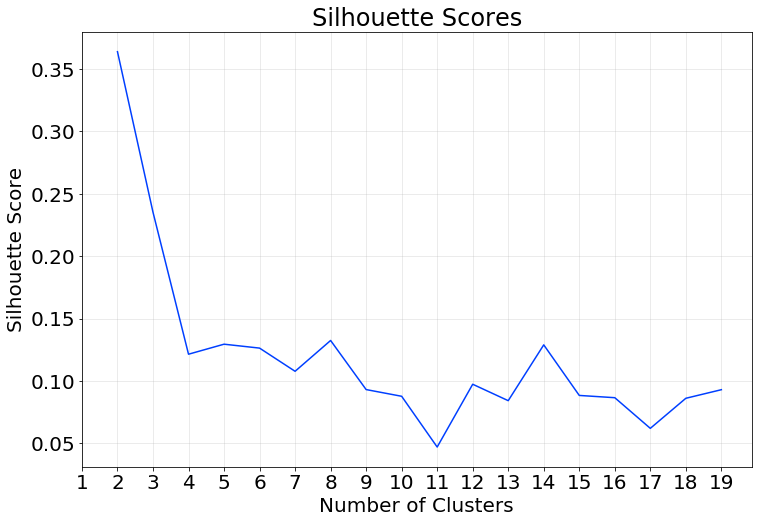

In [104]:
clusters_ss = np.arange(2,20)

plt.figure(figsize=(12,8))
plt.title('Silhouette Scores')
plt.plot(clusters_ss, ss_arr)
plt.grid(alpha=0.3)
plt.xticks(clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score');

## Heirarchal Clustering

In [105]:
def heir_clust(X_hc, thresh, dist_metric='cosine', num_params_to_display=50):
    # Find distances using pair-wise distances in the array, according to desired metric
    dist = squareform(pdist(X_hc.values.T, metric = dist_metric))

    # Plot dendrogram
    fig, axarr = plt.subplots(nrows = 3, ncols = 1, figsize=(60, 80))
    for ax, linkmethod in zip(axarr.flatten(), ['single', 'complete', 'average']):
        clust = linkage(dist, method=linkmethod)
        dendrogram(clust, ax=ax, truncate_mode='lastp', p=num_params_to_display, labels=model_mask_cols, 
                   color_threshold=thresh, leaf_font_size=25) #color threshold number sets the color change
        ax.set_title('{} linkage'.format(linkmethod), fontsize=40)
        ax.grid(alpha=0.3)
    plt.savefig('images/clust.png'.format(linkmethod))

/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:704: RuntimeWarning: invalid value encountered in greater_equal
  if np.all(y >= 0) and np.allclose(y, y.T):


ValueError: The condensed distance matrix must contain only finite values.

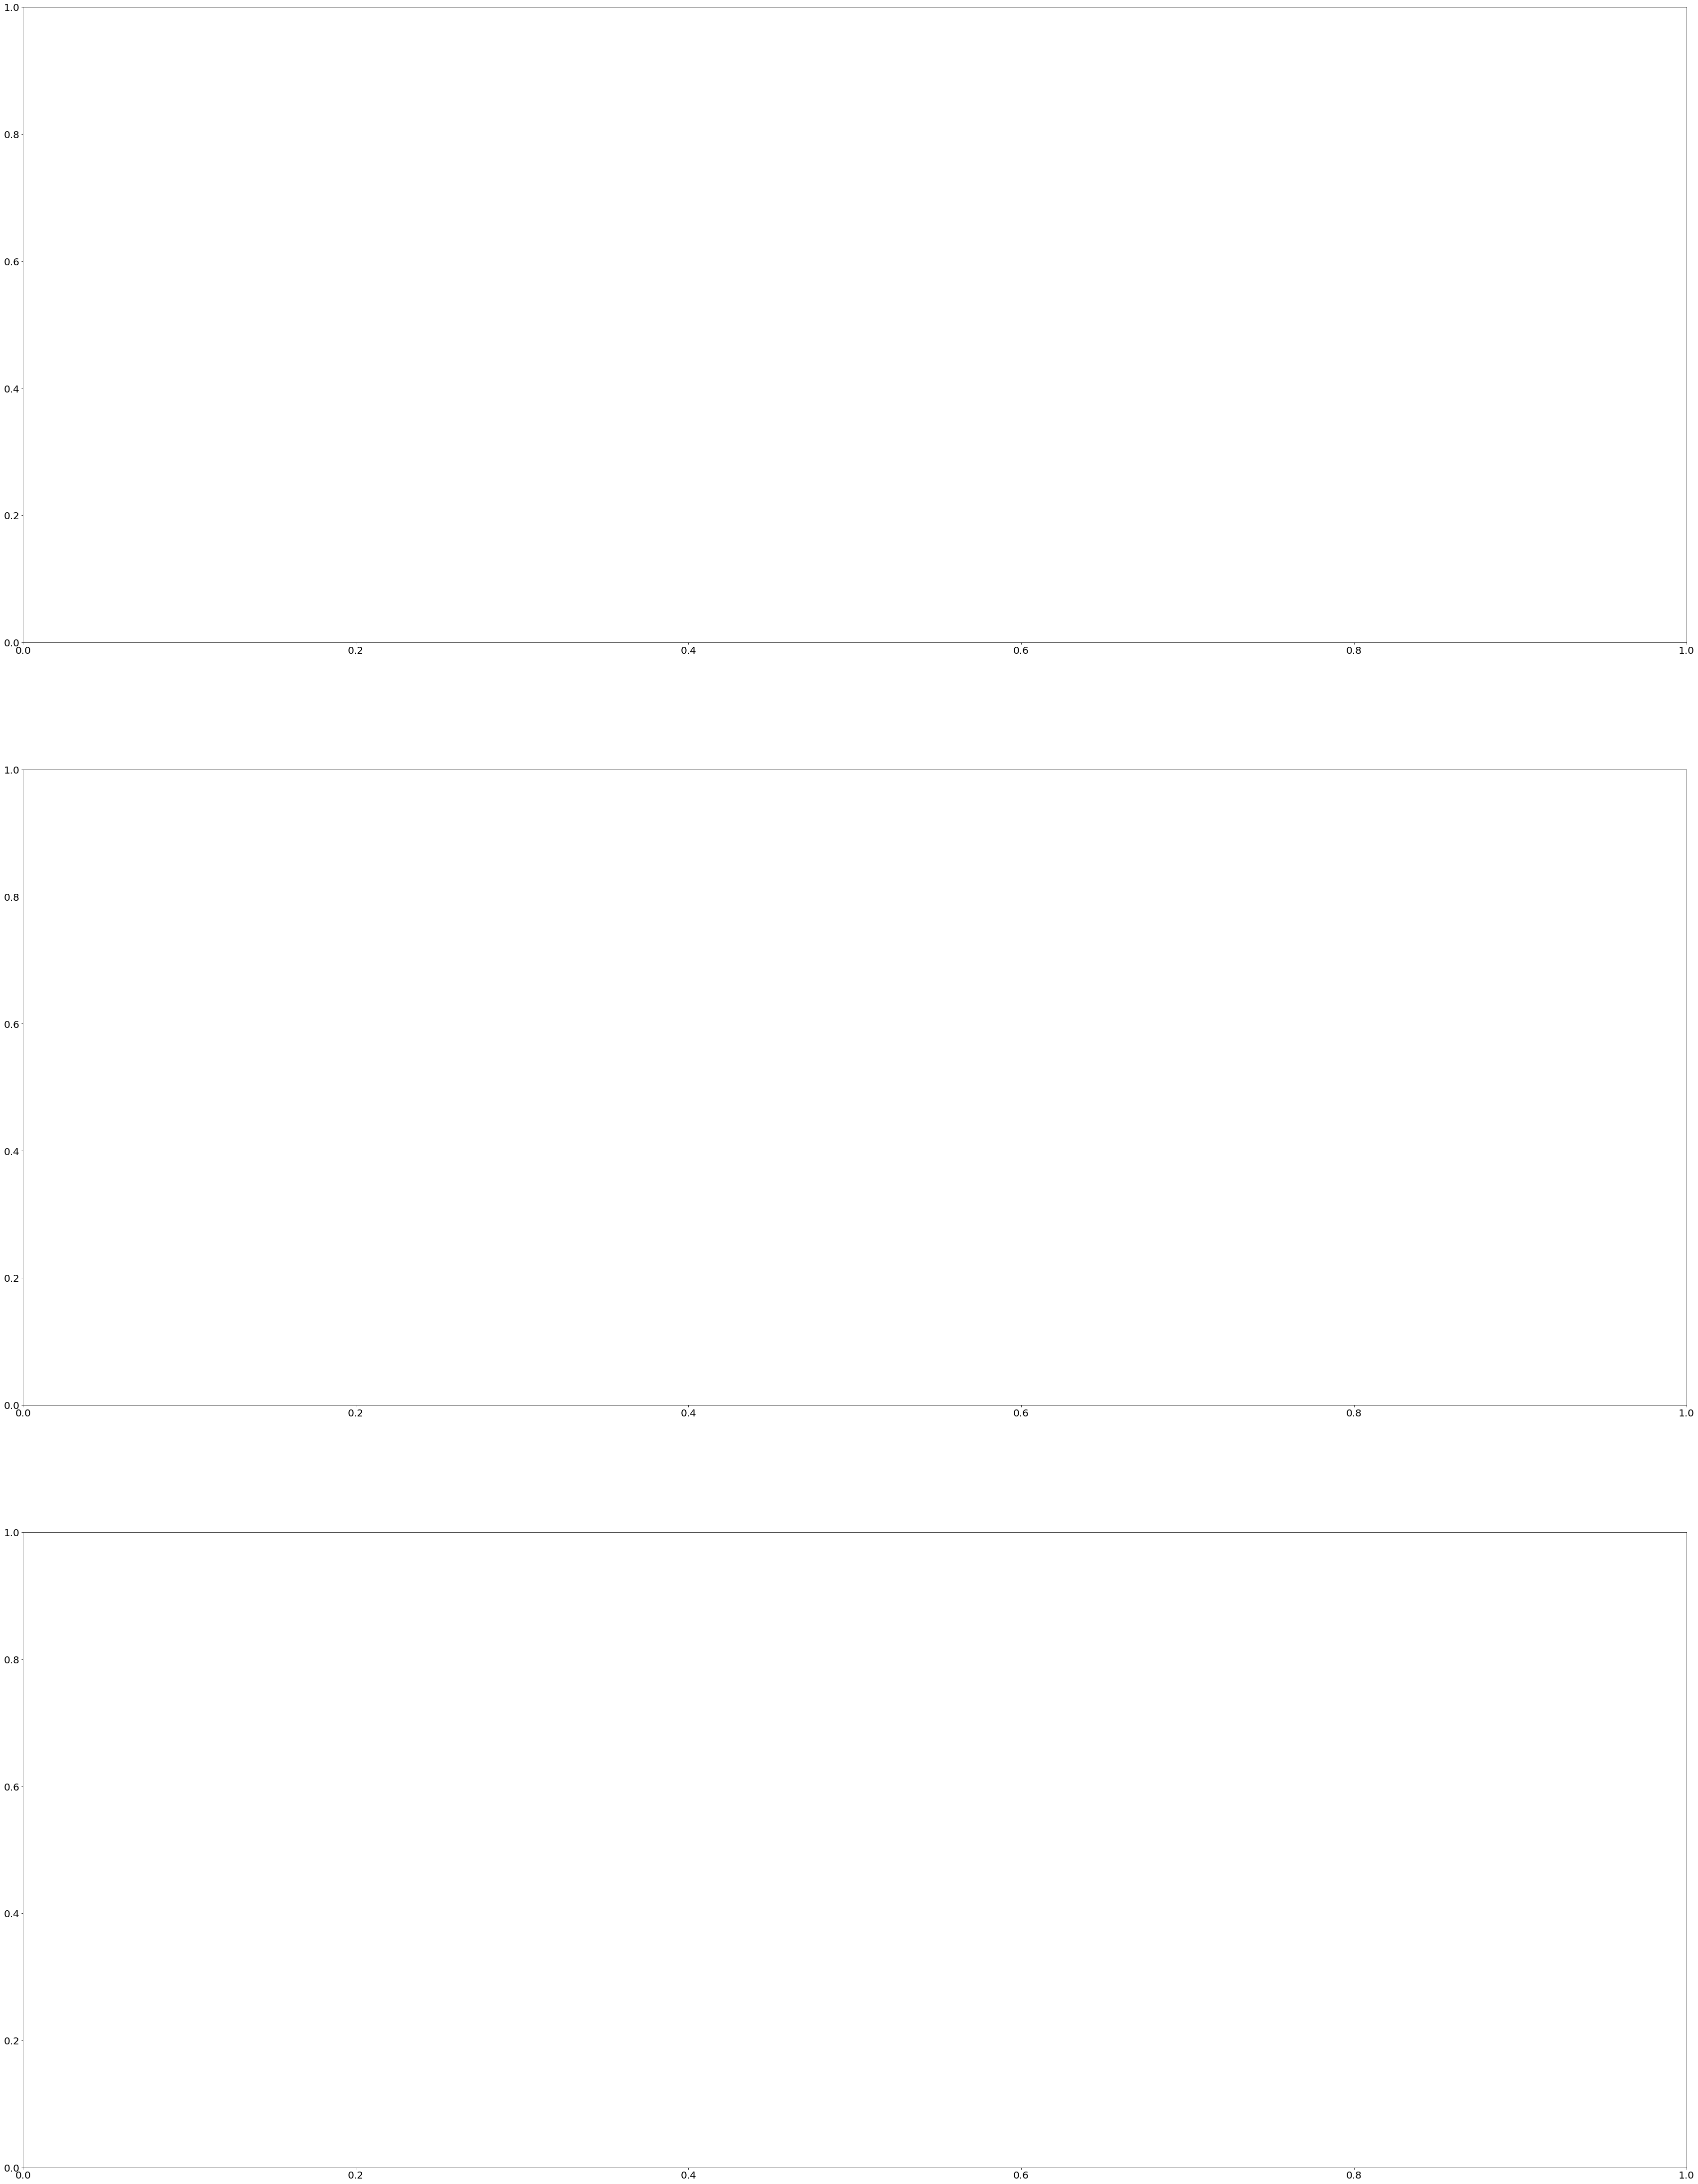

In [106]:
heir_clust(X_train[model_mask_cols], thresh=1.6)

# Regression Models
Regression models to try:
    - Linear regression (with additional complexity)
    - Random forest
    - Boosting
    - Gradient descent
    - Neural net

## OLS

In [108]:
def ols(X_train, X_test, y_train, y_test):
    ols = OLS(y_train, add_constant(X_train.values, has_constant='add'))
    result = ols.fit()
    pred = result.predict(add_constant(X_test.values, has_constant='add'))
    score = mean_squared_error(y_test, pred)
    print('Root Mean Square Error: ',score)
    names = list(X_train.columns)
    names.insert(0,'Constant')
    print(result.summary(xname=names))

In [109]:
ols(X_train[model_mask_cols], X_test[model_mask_cols], y_train, y_test)

Root Mean Square Error:  0.025421171360039407
                            OLS Regression Results                            
Dep. Variable:     qty_shrink_per_day   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     1230.
Date:                Thu, 18 Jan 2018   Prob (F-statistic):               0.00
Time:                        12:35:17   Log-Likelihood:                -1483.6
No. Observations:               29538   AIC:                             3035.
Df Residuals:                   29504   BIC:                             3317.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [110]:
for val in X_train.item_category.unique():
    print('Item cat: ', val)
    mask = X['item_category_{}'.format(val)] == 1
    X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X[mask], y[mask], test_size=0.2)
    size = len(X_train_temp)
    print('Size: ', size)
    if size < 30:
        continue
    ols(X_train_temp[model_mask_cols], X_test_temp[model_mask_cols], y_train_temp, y_test_temp)

Item cat:  16
Size:  15217
Root Mean Square Error:  0.014106293352351916


/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


                            OLS Regression Results                            
Dep. Variable:     qty_shrink_per_day   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     530.4
Date:                Thu, 18 Jan 2018   Prob (F-statistic):               0.00
Time:                        12:36:13   Log-Likelihood:                 8700.3
No. Observations:               15217   AIC:                        -1.735e+04
Df Residuals:                   15191   BIC:                        -1.715e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Constant              

Root Mean Square Error:  0.010352800325689972
                            OLS Regression Results                            
Dep. Variable:     qty_shrink_per_day   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     52.94
Date:                Thu, 18 Jan 2018   Prob (F-statistic):           2.92e-89
Time:                        12:36:13   Log-Likelihood:                 408.10
No. Observations:                 359   AIC:                            -776.2
Df Residuals:                     339   BIC:                            -698.5
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

## Random Forest

In [127]:
def class_crossval(X, y, models, scoring='neg_mean_squared_error'):
    seed = 123
    results = []
    names = []
    all_scores = []
    print('Mod - Avg - Std Dev')
    print('---   ---   -------')
    for name, model in models:
        print(model)
        kfold = model_selection.KFold(n_splits=10, random_state=seed)
        cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        all_scores.append(cv_results.mean())
        print('{}: {:.2f} ({:2f})'.format(name, cv_results.mean(), cv_results.std()))
    print('Avg of all: {:.3f}'.format(np.mean(all_scores)))
    fig = plt.figure(figsize=(12, 12))
    fig.suptitle('Algorithm Comparison of CrossVal Scores')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    ax.set_ylabel('K-Fole CV Accuracy')
    ax.set_xlabel('Model')
    plt.show()

In [ ]:
# Initial Cross Validation
models = []
models.append(('LIN', LinearRegression()))
models.append(('RIG', Ridge()))
models.append(('LAS', Lasso()))
#models.append(('MTL', MultiTaskLasso()))
models.append(('SGD', SGDRegressor()))
models.append(('SVR', SVR()))
models.append(('GPR', GaussianProcessRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('AB', AdaBoostRegressor()))
models.append(('GB', GradientBoostingRegressor()))
models.append(('MLP', MLPRegressor(alpha=1)))

class_crossval(X_train[model_mask_cols], y_train, models)

Mod - Avg - Std Dev
---   ---   -------
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
LIN: -0.07 (0.074617)
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
RIG: -0.07 (0.074621)
Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
LAS: -0.15 (0.083225)
SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)


/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/hom

SGD: -0.07 (0.074705)
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


# Forcasting/Time Series
 - Inclusion of endog (target) variable into predictive model/forcast
 - Explore various techniques outlined statsmodels.pdf
 - Try LSTM neural net

In [ ]:
df[ df.item_description == '5 HR-XSTRENGTH BLUE RASPBERRY'].head(5)

In [ ]:
X_train_ss.groupby('address1').count().sort_values('item_UPC', ascending=False)

In [ ]:
plt.scatter(X_train.prev_item_move_date_int.values, X_train.prev_visit_date_int.values, alpha=0.01)

In [ ]:
foo = df[ df.address1 == 'SPEEDWAY #1224']
plt.figure(figsize=(12,12))
plt.scatter(foo.visit_date.values, foo.qty_shrink.values, c=foo.item_UPC.values)
plt.xticks(rotation=45)
plt.legend()

In [ ]:
def cat_plot_sales():
    freq = '2w'
    item_filt = df.groupby(['item_category', pd.Grouper(key='visit_date', freq=freq)]).mean().reset_index()
    fig = plt.figure(figsize=(12,12))
    i = 1
    for cat in item_filt.item_category.unique():
        if cat == '41':
            continue
        foo = item_filt[ item_filt.item_category == cat]
        ax = fig.add_subplot(1,1,1)
        ax.plot(foo.visit_date, foo.sales_value, label=cat)
        ax.set_xticklabels(foo.visit_date, rotation=45, ha='right')
    plt.legend()
    plt.ylabel('Average Lost Sales/{} ($)'.format(freq))
    plt.xlabel('Date')
    plt.grid(alpha=0.3)
    plt.title('Average Sales Loss Across All Stores by Cat')
    
cat_plot_sales()

In [ ]:
def cat_plot_shrink():
    freq = '2w'
    item_filt = df.groupby(['item_category', pd.Grouper(key='visit_date', freq=freq)]).mean().reset_index()
    fig = plt.figure(figsize=(12,12))
    i = 1
    for cat in item_filt.item_category.unique():
        if cat == '41':
            continue
        foo = item_filt[ item_filt.item_category == cat]
        ax = fig.add_subplot(1,1,1)
        ax.plot(foo.visit_date, foo.qty_shrink, label=cat)
        ax.set_xticklabels(foo.visit_date, rotation=45, ha='right')
    plt.legend()
    plt.ylabel('Average Shrink/{} ($)'.format(freq))
    plt.xlabel('Date')
    plt.grid(alpha=0.3)
    plt.title('Average Shrink Loss Across All Stores by Cat')
    
    
cat_plot_shrink()

In [ ]:
def st_plot_sales():
    freq = '20d'
    item_filt = df.groupby(['state', pd.Grouper(key='visit_date', freq=freq)]).mean().reset_index()
    fig = plt.figure(figsize=(40,60))
    i = 1
    count = 0
    for state in item_filt.state.unique():
        count += 1
        if count % 9 == 0:
            i += 1
        foo = item_filt[ item_filt.state == state]
        ax = fig.add_subplot(3,2,i)
        ax.plot(foo.visit_date, foo.sales_value, label=state)
        ax.set_xticklabels(foo.visit_date, rotation=45, ha='right')
        ax.legend()
        ax.set_ylabel('Average Lost Sales/{} ($)'.format(freq))
        ax.set_xlabel('Date')
        ax.grid(alpha=0.3)
        ax.set_title('Average Sales Loss Across Cat by State')
    
st_plot_sales()

In [ ]:
plt.figure(figsize=(20,4))
plt.scatter(df.visit_date.values, df.shrink_value.values, alpha=0.2)
plt.yscale('log')
plt.yticks([0.1,1,10])


In [ ]:
df.groupby(['state', pd.Grouper(key='visit_date', freq='w')]).head()

In [ ]:
def st_plot_shrink():
    freq = '20d'
    item_filt = df.groupby(['state', pd.Grouper(key='visit_date', freq=freq)]).mean().reset_index()
    fig = plt.figure(figsize=(40,60))
    i = 1
    count = 0
    for state in item_filt.state.unique():
        count += 1
        if count % 9 == 0:
            i += 1
        foo = item_filt[ item_filt.state == state]
        ax = fig.add_subplot(3,2,i)
        ax.plot(foo.visit_date, foo.qty_shrink, label=state)
        ax.set_xticklabels(foo.visit_date, rotation=45, ha='right')
        ax.legend()
        ax.set_ylabel('Average Shrink/{} ($)'.format(freq))
        ax.set_xlabel('Date')
        ax.grid(alpha=0.3)
        ax.set_title('Average Shrink Loss Across Cat by State')
    
st_plot_shrink()

In [ ]:
crime = pd.read_pickle('data/Crime/crime_clean.pkl')

In [ ]:
def crime_plot():
    freq = 'w'
    item_filt = crime.groupby([pd.Grouper(key='date', freq=freq)]).count().reset_index()
    plt.figure(figsize=(20,8))
    plt.plot(item_filt.date, item_filt.city)
    plt.grid(alpha=0.4)
crime_plot()

In [ ]:
def fit_lstm(X_train, y, batch_size, nb_epoch, neurons):
    X = X_train[]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [ ]:
fit_lstm(X_train, y, None, 1, 20)

# Questions
1. Why are there two salesman ID columns?
2. Which columns are unknown (ie anything inventory out or equivalent)?
3. Target is qty_shrink?
4. What does customer_id represent? It has more values than address1

# Other Data Sources
 - Crime data
 - Food desserts (people that may rely on gas stations for food)
 - Average income
 - Population density

In [ ]:
pd.get_dummies(df, columns=['state'])

In [ ]:
foo = pd.DataFrame()
foo[['a', 'b']] = df[['visit_date', 'address1']]

In [ ]:
foo.head()

# POA
- Create averages:
    - Avg qty shrink/day, shink_sales/day, etc
- Engineer lag terms (ie last visit, last month, last season)
    - Use these in whatever model I want
    - Use the averaged values